# Planetary Nebula <a class="tocSkip">
    
This notebook is used to test and showcase the results of my first project. I use spectroscopic data from the [Multi Unit Spectroscopic Explorer](https://www.eso.org/sci/facilities/develop/instruments/muse.html) (MUSE) that has been observed as part of the [PHANGS](https://sites.google.com/view/phangs/home) collaboration.
    
I will use a set of line maps of emission lines to identify Planetary Nebula in the data an measure their brightness. This can then be used to fit an empiric relation and hence measure the distance to the galaxy.
    
This notebook is used for developement. Final code is moved to the `pymuse` packge in the `src` folder. Any production scripts reside in the `scripts` folder.

## Preparation
 
### Load Basic Packages
    
First we load a bunch of common packages that are used across the project. More specific packages that are only used in one section are loaded later to make it clear where they belong to (this also applies to all custom moduls that were written for this project).

In [ ]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from pymuse.packages import *

from pymuse.constants import tab10, single_column, two_column

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

we use the `logging` module to handle informations and warnings (this does not always work as expected in jupyter notebooks).

In [ ]:
logging.basicConfig(stream=sys.stdout,format='%(levelname)s: %(message)s',level=logging.INFO)
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

### Read in data

this uses the `ReadLineMaps` class from the `pymuse.io` module. To use it, we first need to specify the path to the data folder

In [ ]:
from pymuse.io import ReadLineMaps

#with open(basedir / 'data' / 'interim' / 'parameters.json') as json_file:
#    parameters = json.load(json_file)
with open(basedir / 'data' / 'interim' / 'parameters.yml') as yml_file:
    parameters = yaml.load(yml_file,Loader=yaml.FullLoader)
    
# table to save all results
results = ascii.read(basedir/'data'/'interim'/ 'results.txt',format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
results.add_index('name')    

name = 'NGC0628'

# first we need to specify the path to the raw data
basedir = Path('..')
data_raw = basedir / 'data' / 'raw' / 'MUSE' / 'DR2'
#data_raw = Path('d:\downloads\MUSEDAP')
#data_ext = Path('g:\Archive')

extensions = ['OIII5006', 'HA6562', 'NII6583', 'SII6716']

# read in the data we will be working with and print some information
galaxy = ReadLineMaps(data_raw,name,extensions,**parameters[name])

### Star Masks

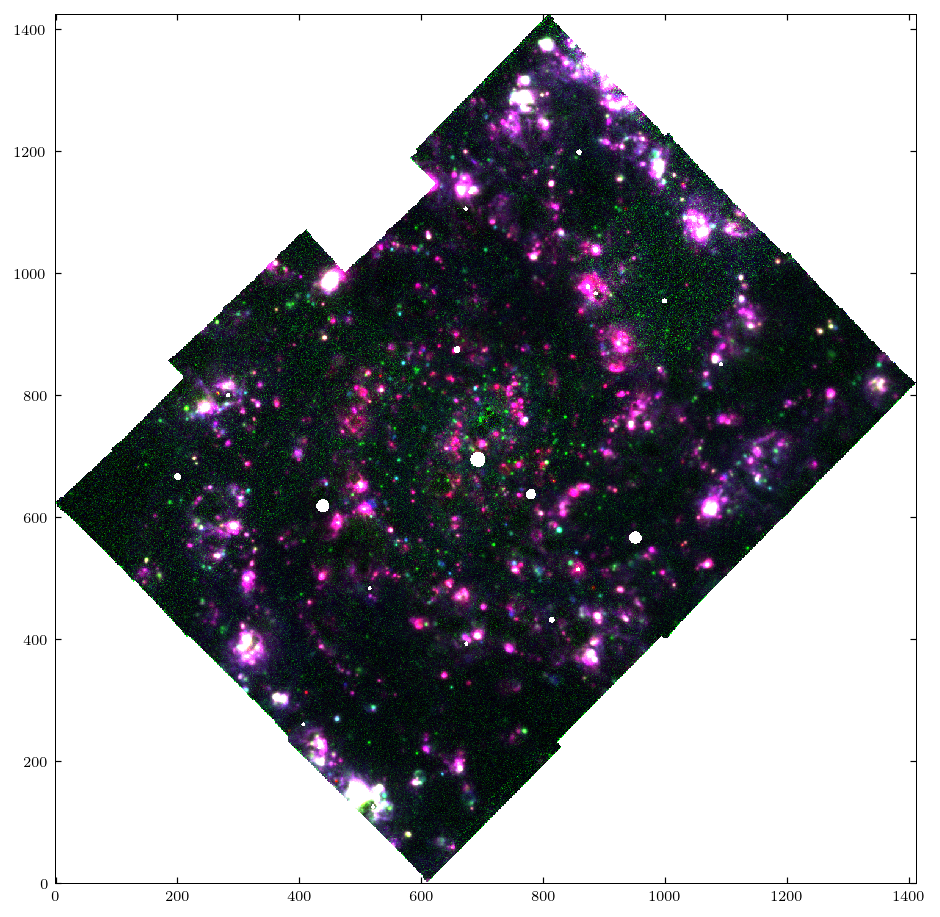

In [4]:
from pymuse.auxiliary import circular_mask
from pymuse.plot.plot import create_RGB
    
mask = np.zeros(galaxy.shape,dtype=bool)
mask |= galaxy.star_mask.astype(bool)

# define masks as slices
masks = {
 'NGC1300' : circular_mask(*galaxy.shape,radius=50),
 'NGC1365' : circular_mask(*galaxy.shape,(720,420),radius=200),
 'NGC1512' : circular_mask(*galaxy.shape,radius=70),
 'NGC1566' : circular_mask(*galaxy.shape,(450,450),radius=100)|circular_mask(*galaxy.shape,(350,150),radius=180),
 'NGC1672' : circular_mask(*galaxy.shape,(600,310),radius=100),
 'NGC3627' : circular_mask(*galaxy.shape,(330,740),radius=100),
 'NGC3351' : circular_mask(*galaxy.shape,radius=200),
 'NGC4535' : circular_mask(*galaxy.shape,(300,520),radius=100)
}

mask[masks.get(galaxy.name,(slice(-1,0),slice(-1,0)))] = True

#img = galaxy.OIII5006_DAP.copy()
img = create_RGB(galaxy.HA6562,galaxy.OIII5006_DAP,galaxy.SII6716,weights=[0.6,1,0.6],percentile=[95,99.,95])
img[mask,...] = (1,1,1)

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot()

#norm = simple_norm(galaxy.OIII5006_DAP,clip=False,max_percent=95)
ax.imshow(img,origin='lower')
plt.show()

## Source Detection

There are two different approaches to identifying sources in an image. The first utilizes PSF fitting and uses implementations from astropy. The other uses the external `SExtractor` package which detects peaks and classifies them with a neural network.

### Based on IRAFStarFinder or DAOStarFinder

The sources we are searching for are unresolved. However due to seeing, they will be smeared out. This PSF has the form of a Gaussian (or Moffat). The subsequent algorithms use this and try to fit a theoretical curve to the observed peaks in the image. If the fit aggrees within some threshold, it reports the peak as a source. The advantage is that for crowded fields, the algorithm will try to fit an individual function to each peak and thus enable us correctly identfiy objects that are closeby.

The following function is based on this tutorial 

https://photutils.readthedocs.io/en/stable/detection.html

https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder

**Requires**
 * A `photutils` starfinder. This can be either `DAOStarFinder` or `IRAFStarFinder`
 * `detect_unresolved_sources`
 
**Returns**
 * `sources` a table with the position of all identified sources

In [ ]:
from photutils import DAOStarFinder            # DAOFIND routine to detect sources
from photutils import IRAFStarFinder           # IRAF starfind routine to detect star

from pymuse.detection import detect_unresolved_sources

In [ ]:
# we include all sources in this step and reject bad ones later
sharplo   = 0.0 #galaxy.sharplo
sharphi   = 1.0 #galaxy.sharphi
roundness = 1.0 #galaxy.roundness

sources = detect_unresolved_sources(galaxy,
                                    'OIII5006_DAP',
                                    StarFinder=DAOStarFinder,
                                    threshold=galaxy.threshold,
                                    exclude_region=mask,
                                    oversize=1,
                                    roundlo=-roundness,
                                    roundhi=roundness,
                                    sharplo=sharplo,
                                    sharphi=sharphi,
                                    save=False)

#### Compare to Kreckel et al. 2017

As mentioned in the beginning, we compare the newly detected sources to those from Kreckel et al. (2017). 

**Requires**
 * `match_coordinates_sky` from `astropy.coordinates` to compare the two catalogues.
 * `Angle` from `astropy.coordinates` to set a maximum seperation in units of arcseconds.

In [ ]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)

tolerance = '0.5s'
ID, angle, Quantity  = match_coordinates_sky(pn_NGC628_kreckel['SkyCoord'],sources['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'{within_tolerance} of {len(angle)} match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')
print(f'mean seperation is {angle[angle.__lt__(Angle(tolerance))].mean().to_string(u.arcsec,decimal=True)}"')

#### Compare to Herrmann 2008 for NGC628

In [ ]:
matchcoord = search_table(pn_herrmann,'M74')
matchcoord['x'],matchcoord['y']= matchcoord['SkyCoord'].to_pixel(wcs=galaxy.wcs)

matchcoord['in_frame'] = False
x_dim,y_dim = galaxy.shape

for row in matchcoord:
    txt,x,y = row['ID'], row['x'], row['y']    
    if 0<=int(x)<x_dim and 0<=int(y)<y_dim:
        if not np.isnan(galaxy.PSF[int(x),int(y)]):
            row['in_frame'] = True

matchcoord = matchcoord[matchcoord['in_frame']]
#matchcoord = matchcoord[matchcoord['in_frame']]
#data = [d for d in matchcoord['m5007']]
#data = matchcoord[matchcoord['in_frame']]['m5007']

In [ ]:
fig = plt.figure(figsize=(6.974,6.974))
ax1 = fig.add_subplot(111,projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
ax1.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues_r)

ax1.scatter(matchcoord['x'],matchcoord['y'],marker='o',s=2,c='tab:red')
for row in matchcoord:
    txt,x,y = row['ID'], row['x']+5, row['y']    
    ax1.annotate(txt, (x, y),fontsize=4,color='tab:red')
    
plt.savefig(basedir / 'reports' / 'NGC628_Herrmann.pdf',dpi=600)

In [ ]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)

# ((tbl['type']=='PN') | (tbl['type']=='SNR')) & 
catalogcoord = tbl[(tbl['mOIII']<27.5)]
    
tolerance = '1s'
ID, angle, Quantity  = match_coordinates_sky(matchcoord['SkyCoord'],catalogcoord['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'{within_tolerance} of {len(angle)} match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')
print(f'mean seperation is {angle[angle.__lt__(Angle(tolerance))].mean().to_string(u.arcsec,decimal=True)}"')

In [ ]:
idx, angle, quan = match_coordinates_sky(SkyCoord('01h36m41.76s','15d47m57.4s'),catalogcoord['SkyCoord'])
catalogcoord[idx]

In [ ]:
from photutils import CircularAperture
from pymuse.plot.plot import create_RGB
rgb = create_RGB(galaxy.SII6716,galaxy.HA6562,galaxy.OIII5006_DAP,percentile=96)

fig = plt.figure(figsize=(6.974,6.974))
ax1 = fig.add_subplot(111,projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
#ax1.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues)
ax1.imshow(rgb)

positions = np.transpose([matchcoord['x'],matchcoord['y']])
apertures = CircularAperture(positions, r=6)
apertures.plot(color='tab:red',lw=.3, alpha=1,ax=ax1)

positions = np.transpose([catalogcoord['x'],catalogcoord['y']])
apertures = CircularAperture(positions, r=6)
apertures.plot(color='tab:orange',lw=.3, alpha=1,ax=ax1)

for row in matchcoord:
    txt,x,y = row['ID'], row['x']+5, row['y']    
    ax1.annotate(txt, (x, y),fontsize=4,color='tab:red')
    
plt.savefig(basedir / 'reports' / 'NGC628_Herrmann.pdf',dpi=600)

In [ ]:
matchcoord['type'] = catalogcoord[ID]['type']
matchcoord['sep']  = angle
matchcoord['mOIII'] = catalogcoord[ID]['mOIII']
matchcoord['dmOIII'] = catalogcoord[ID]['dmOIII']

fig,ax = plt.subplots(figsize=(7,7))

# we only use sources when their position agrees within this tolerance
tolerance = '1.0"'

ax.errorbar(matchcoord[matchcoord['sep'].__lt__(Angle(tolerance))]['m5007'],
            matchcoord[matchcoord['sep'].__lt__(Angle(tolerance))]['mOIII'],
            yerr=3*matchcoord[matchcoord['sep'].__lt__(Angle(tolerance))]['dmOIII'],
            xerr=0.15,
            fmt='o')

ax.scatter(matchcoord[matchcoord['sep'].__gt__(Angle(tolerance))]['m5007'],
           matchcoord[matchcoord['sep'].__gt__(Angle(tolerance))]['m5007'],color='tab:red')

ax.plot([25.3,27.5],[25.3,27.5],color='black',lw=0.4)
ax.plot([25.3,27.5],[24.8,27.],color='black',lw=0.2,ls='--')
ax.plot([25.3,27.5],[25.8,28.],color='black',lw=0.2,ls='--')
ax.set_xlabel(r'$\mathrm{m}_{[\mathrm{OIII}]}$ Herrmann et al. 2008',fontsize=16)
ax.set_ylabel(r'$\mathrm{m}_{[\mathrm{OIII}]}$ this work',fontsize=16)

plt.show()

#### Compare to Herrmann 2008 for NGC5068

In [ ]:
matchcoord = pn_NGC5068
matchcoord['x'],matchcoord['y']= matchcoord['SkyCoord'].to_pixel(wcs=galaxy.wcs)

matchcoord['in_frame'] = False
x_dim,y_dim = galaxy.shape

for row in matchcoord:
    txt,x,y = row['ID'], row['x'], row['y']    
    if 0<=int(x)<x_dim and 0<=int(y)<y_dim:
        if not np.isnan(galaxy.PSF[int(x),int(y)]):
            row['in_frame'] = True

matchcoord = matchcoord[matchcoord['in_frame']]
#matchcoord = matchcoord[matchcoord['in_frame']]
#data = [d for d in matchcoord['m5007']]
#data = matchcoord[matchcoord['in_frame']]['m5007']

In [ ]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)

# ((tbl['type']=='PN') | (tbl['type']=='SNR')) & 
catalogcoord = tbl[(tbl['mOIII']<28.5)]
    
tolerance = '1s'
ID, angle, Quantity  = match_coordinates_sky(matchcoord['SkyCoord'],catalogcoord['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'{within_tolerance} of {len(angle)} match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')
print(f'mean seperation is {angle[angle.__lt__(Angle(tolerance))].mean().to_string(u.arcsec,decimal=True)}"')

In [ ]:
angle

In [ ]:
fig = plt.figure(figsize=(6.974,6.974))
ax1 = fig.add_subplot(111,projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
ax1.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues_r)

ax1.scatter(matchcoord['x'],matchcoord['y'],marker='o',s=2,c='tab:red')
for row in matchcoord:
    txt,x,y = row['ID'], row['x']+5, row['y']    
    ax1.annotate(txt, (x, y),fontsize=4,color='tab:red')
    
#plt.savefig(basedir / 'reports' / 'NGC5068_Herrmann.pdf',dpi=600)

In [ ]:
from photutils import CircularAperture
from pymuse.plot.plot import create_RGB
rgb = create_RGB(galaxy.SII6716,galaxy.HA6562,galaxy.OIII5006_DAP,percentile=96)

fig = plt.figure(figsize=(6.974,6.974))
ax1 = fig.add_subplot(111,projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
#ax1.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues)
ax1.imshow(rgb)

positions = np.transpose([matchcoord['x'],matchcoord['y']])
apertures = CircularAperture(positions, r=6)
apertures.plot(color='tab:red',lw=.3, alpha=1,ax=ax1)

positions = np.transpose([catalogcoord['x'],catalogcoord['y']])
apertures = CircularAperture(positions, r=6)
apertures.plot(color='tab:orange',lw=.3, alpha=1,ax=ax1)

for row in matchcoord:
    txt,x,y = row['ID'], row['x']+5, row['y']    
    ax1.annotate(txt, (x, y),fontsize=4,color='tab:red')
    
plt.savefig(basedir / 'reports' / 'NGC5068_Herrmann.pdf',dpi=600)

#### Plot detected sources

In [ ]:
from pymuse.plot.plot import plot_sky_with_detected_stars

In [ ]:
position = np.transpose((sources['x'], sources['y']))
positions_kk = np.transpose(pn_bright['SkyCoord'].to_pixel(wcs=galaxy.wcs))
positions = (position,positions_kk)

save_file = Path.cwd() / '..' / 'reports' / 'figures' / f'{galaxy.name}_sky_sources_DAO.pdf'
plot_sky_with_detected_stars(data=galaxy.OIII5006_DAP,
                             wcs=galaxy.wcs,
                             positions=positions,
                             filename=save_file)

#### Cut out detected stars

In [ ]:
from pymuse.plot.plot import sample_cutouts

In [ ]:
save_file = Path.cwd() / '..' / 'reports' / 'figures' / f'{galaxy.name}_stars.pdf'

stars = sample_cutouts(galaxy.OIII5006_DAP,sources,galaxy.wcs,nrows=4,ncols=4)

### Using SExtractor

there is no Python implementation of SExtractor. Instead we run it from the command line

```
sextractor file.fits -c default.sex
```

this will produce a file `test.cat` which contains the position of the sources. We read this table and calculate the sky position wiht astropy

In [ ]:
def get_fwhm(x,y):
    try:
        return galaxy.PSF[int(y),int(x)]
    except:
        return 0
    
file = data_raw /  'NGC628.cat'

sources = ascii.read(file)
sources.rename_columns(['X_IMAGE','Y_IMAGE'],['x','y'])
sources['fwhm'] = np.array([get_fwhm(x,y) for x,y in zip(sources['x'],sources['y'])])
sources['sharpness']  = 0.3
sources['roundness2'] = 0.3

print(f'{len(sources)} sources found')

#### Match with known sources

In [ ]:
ID, angle, Quantity  = match_coordinates_sky(pn_bright['SkyCoord'],table['SkyCoord'])
within_1_arcsec = len(angle[angle.__lt__(Angle("0.5s"))])

print(f'{within_1_arcsec} of {len(angle)} match within 0.5": {within_1_arcsec / len(angle)*100:.1f} %')
print(f'mean seperation is {angle.mean().to_string(u.arcsec,decimal=True)}"')
#print(f'mean angle: {angle.mean():.2f}')

#### Plot detected sources

this requires the previously loaded `plot_sources` from `pymuse.plot`

In [ ]:
file = Path.cwd() / '..' / 'reports' / 'figures' / f'{NGC628.name}_sources_sextractor.pdf'

position = np.transpose((sources['x'], sources['y']))
references = np.transpose(pn_bright['SkyCoord'].to_pixel(wcs=NGC628.wcs))
positions = (position,references)

sky_with_detected_stars(data=NGC628.OIII5006_old,wcs=NGC628.wcs,positions=positions,filename=file)

## Completeness limit

In [ ]:
from pymuse.detection import completeness_limit

In [ ]:
mock_sources = completeness_limit(
                    galaxy,
                    'OIII5006',
                    DAOStarFinder,
                    iterations=10,
                    threshold=threshold,
                    exclude_region=mask,
                    oversize=oversize,
                    roundlo=-roundness,
                    roundhi=roundness,
                    sharplo=sharplo,
                    sharphi=sharphi,
                    exclude_border=True,
                    )

## Flux measurement

In the previous step we detected potential PN candidates by their [OIII] emission. This means we know their position but lack exact flux measurments. In this section we measure the flux of the identified objects in different emission lines that are used in later steps. 

### Growth curve analysis



#### Gaussian

A shape that is commonly used for the PSF is that of a 2D gaussian (we assume  variance of $\sigma_x^2 = \sigma_y^2 = \sigma^2$). If we center the peak at the origin the PSF is described by
$$
f(x,y) = A \exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)
$$
with some amplitude $A$. We can rewrite this in polar coordinates as 
$$
f(r,\phi) = A \exp\left(-\frac{r^2}{2\sigma^2}\right)
$$
The light inside an aperture of radius $P(R)$ is given by the integral
$$
P(R) = \int_0^{2\pi} \int_0^R f(r,\phi) \mathrm{d} \phi r \mathrm{d} r = 2\pi \sigma^2 A \left(1-\exp \left(-\frac{R^2}{2\sigma^2}\right) \right) 
$$
We are interested in the ratio $p(R) = P(R) / P(\infty)$. If we use the relation between the standard deviation and the $\mathrm{FWHM}$ of a Gaussian $\sigma = \frac{\mathrm{FWHM}}{2\sqrt{2\ln2}}$, we can write
$$
\begin{align}p(R) = 1-\exp\left(- \frac{4 \ln 2 \cdot R^2}{\mathrm{fwhm}^2} \right)\end{align}
$$


#### Moffat

The measured FWHM are systematically larger than the reported values. A possible cause is that the shape of the PSF is not a perfect Gaussian, but rather described by a [Moffat](https://en.wikipedia.org/wiki/Moffat_distribution). This distribution is larger towards the wings and fitting a Gaussian to such a shape should result in a larger FWHM

$$
f(R;\alpha,\gamma) = A \left[1 + \left(\frac{R}{\gamma}\right)^2 \right]^{- \alpha}
$$

**Note**: this nomenclature follows `astropy` and contradicts the commonly used scheme which uses $\gamma=\alpha$ and $\alpha=\beta$.

The Full Width Half Maximum of this function is given by
$$
\mathrm{FWHM} = 2\gamma \sqrt{2^{1/\alpha}-1}
$$

like we did for the Gaussian we can calculate the amount of flux within a radius R as 

$$
\begin{align}
P(R) = \int_0^{2\pi} \int_0^R f(r,\phi) \mathrm{d} \phi r \mathrm{d} r = 2\pi \int_0^R A \left[1 + \left(\frac{r}{\gamma}\right)^2 \right]^{- \alpha} r \mathrm{d} r
\end{align}
$$

to solve this we substitute $u=1+\left(\frac{r}{\gamma} \right)^2 $ with $\frac{\mathrm{d} u}{\mathrm{d} r} = \frac{2r}{\gamma^2}$. 

$$
\begin{align}
P(R) = A \frac{\gamma^2}{2(1-\alpha)} \left[1 + \left( \frac{R}{\gamma} \right)^2 \right]^{1-\alpha}- A\frac{\gamma^2}{2(1-\alpha)}
\end{align}
$$


again we are interested in the ratio $p(R) = P(R) / P(\infty)$. If we assume that $\alpha>1$, the first term will be $0$ for $R\rightarrow \infty$ and so we end up with 

$$
p(r) = \left[ 1+\left( \frac{R}{\gamma}\right)^2\right]^{1-\alpha} - 1
$$

In [ ]:
from pymuse.photometry import light_in_gaussian, light_in_moffat, fwhm_moffat

alpha = 4
gamma = 10
fwhm = fwhm_moffat(alpha,gamma)
print(f'alpha={alpha:.2f}, gamma={gamma:.2f}, fwhm={fwhm:.2f}')

d = np.arange(0,20,0.2)
g = light_in_gaussian(d,fwhm)
m = light_in_moffat(d,alpha,gamma)
plt.plot(d/fwhm,100*g,label='Gaussian')
plt.plot(d/fwhm,100*m,label='Moffat')

plt.legend()
plt.xlabel('diameter in fwhm')
plt.ylabel('light in aperture in %')
plt.grid()

#### Create an ideal Gaussian/Moffat source and measure growth curve

In [ ]:
from astropy.modeling import models, fitting 
from astropy.nddata import Cutout2D
from astropy.stats import gaussian_sigma_to_fwhm, gaussian_fwhm_to_sigma

from pymuse.photometry import growth_curve
from pymuse.auxiliary import fwhm_moffat

In [ ]:
size=64
fwhm = 10
bkg = 0.5
print(f'fwhm={fwhm}')

std =  fwhm * gaussian_fwhm_to_sigma
gaussian = models.Gaussian2D(x_mean=size/2,y_mean=size/2,x_stddev=std,y_stddev=std)
img = gaussian(*np.indices((size,size))) + np.random.uniform(0,bkg,(size,size))
plt.imshow(img, origin='lower')
plt.show()


In [ ]:
fwhm_fit = growth_curve(img,size/2,size/2,model='gaussian',plot=True)[0]
print(f'fwhm={fwhm}, measured={fwhm_fit:.2f}')

In [ ]:
size=64
alpha = 4.765
gamma = 6/(2*np.sqrt(2**(1/4.76)-1))
bkg = 0.01

fwhm = 2*gamma * np.sqrt(2**(1/alpha)-1)
print(f'alpha={alpha:.2f}, gamma={gamma:.2f}, fwhm={fwhm:.2f}')

std = 4 * gaussian_fwhm_to_sigma
moffat = models.Moffat2D(x_0=size/2,y_0=size/2,alpha=alpha,gamma=gamma)

img = moffat(*np.indices((size,size))) + np.random.uniform(0,bkg,(size,size))
plt.imshow(img, origin='lower')
plt.show()

In [ ]:
fit = growth_curve(img,size/2,size/2,model='gaussian',plot=True,length=10)
fwhm_fit = fit[0]
#fwhm_fit = fwhm_moffat(*fit)

print(f'fwhm={fwhm:.2f}, fit={fwhm_fit:.2f}')

#### Apply to real data

We saw that we can predict the aperture size dependence of the flux for mock sources. Now we pick real objects and try to do the same. 

Stars should have much larger stellar velocities. We use this to identify potential foreground stars in our source catalogue. We cannot use the peaks of the velocity maps as they seem to be displaced from the center of the star.

In [ ]:
from scipy.signal import convolve

from astropy.nddata import Cutout2D
from astropy.stats import gaussian_fwhm_to_sigma

from pymuse.plot import single_cutout
from pymuse.photometry import growth_curve, correct_PSF, fwhm_moffat

we find stars due to their high velocity dispersion

In [ ]:
# define kernel for smoothing
smoothing_length = 10 
kernel = np.ones((smoothing_length,smoothing_length))

# find stars by their large velocity dispersion
star_mask = np.zeros(NGC628.V_STARS.shape,dtype='f8')
star_mask[np.abs(NGC628.V_STARS)>200] = 1

# smooth ouput with convolution
star_mask = convolve(star_mask,kernel,mode='same')
star_mask[star_mask>0.1] = 1
star_mask[star_mask<0.1] = 0
star_mask[np.isnan(NGC628.V_STARS)] = np.nan

In [ ]:
stars = detect_unresolved_sources(NGC628,
                                  'whitelight',
                                   StarFinder=DAOStarFinder,
                                   threshold=5,
                                   oversize_PSF = 1.,
                                   save=False)
    
stars = stars[star_mask[stars['y'].astype(int),stars['x'].astype(int)]==1]

In [ ]:
stars

In [ ]:
i = 0
size = 20
x,y,fwhm = stars[i][['x','y','fwhm']]
single_cutout(NGC628,'whitelight',x,y,size=size)
print(fwhm)

In [ ]:
data = NGC628.HA6562

aperture = 25
fit = growth_curve(data,x,y,model='moffat',rmax=15,plot=True,length=10)
#fwhm_fit=fit[0]
fwhm_fit = fwhm_moffat(*fit)

radius = np.arange(0,10,0.5)
plt.plot(radius,light_in_gaussian(radius,fwhm),label='gaussian',ls='--',color='tab:red')
plt.legend()

print(f'reported={fwhm:.2f}, measured={fwhm_fit:.2f}, ratio={fwhm_fit/fwhm:.2f}')

we have 6 objects classified as stars in our field of view. For each of them we do a growth curve analysis

In [ ]:
size = 20
data = NGC628.whitelight

fig,ax = plt.subplots(figsize=(8,5))

for i in range(len(stars)):
    x,y,fwhm = stars[i][['x','y','fwhm']]

    fit = growth_curve(data,x,y,model='moffat',rmax=30,plot=True,length=10)
    fwhm_fit = fwhm_moffat(*fit)
    print(f'alpha={fit[0]:.2f}, gamma={fit[1]:.2f}, reported={fwhm:.2f}, measured={fwhm_fit:.2f}, ratio={fwhm_fit/fwhm:.2f}')

#### Fit 2D Function

So far we didn't fit the PSF shape directly but took a slight detour with the light inside an aperture. Here we try to fit the 2D functions to the observed data

In [ ]:
size = 16

#sub = sources[sources['peak']>500]
#x,y,fwhm = sub[8][['x','y','fwhm']]

for line, cmap in zip(['whitelight','OIII5006','HA6562'],[plt.cm.viridis,plt.cm.Blues_r,plt.cm.Reds_r]):
    # defien the size of the cutout region
    star = Cutout2D(getattr(NGC628,line), (x,y), u.Quantity((size, size), u.pixel))

    fitter = fitting.LevMarLSQFitter()
    data = star.data
    fig ,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(12,3))
    #cmap = plt.cm.Blues

    ax1.imshow(data,origin='lower',cmap=cmap)
    ax1.set_title(f'image {line}')

    std = fwhm * gaussian_fwhm_to_sigma
    gaussian_theory = models.Gaussian2D(x_mean=size/2,y_mean=size/2,x_stddev=std,y_stddev=std)
    ax2.imshow(gaussian_theory(*np.indices(data.shape)), origin='lower',cmap=cmap)
    ax2.set_title('Gaussian reported')
    
    model = models.Gaussian2D()
    gaussian = fitter(model,*np.indices(data.shape),data,maxiter=1000)
    ax3.imshow(gaussian(*np.indices(data.shape)), origin='lower',cmap=cmap)
    ax3.set_title('Gaussian fit')

    model = models.Moffat2D(alpha=4.765,fixed={'alpha':True}) 
    moffat = fitter(model,*np.indices(data.shape),data,maxiter=2000)
    fwhm_moffat = 2*moffat.gamma.value * np.sqrt(2**(1/moffat.alpha.value)-1)
    ax4.imshow(moffat(*np.indices(data.shape)), origin='lower',cmap=cmap)
    ax4.set_title('Moffat fit')
    
    plt.tight_layout()
    xstd = gaussian.x_stddev * gaussian_sigma_to_fwhm
    ystd = gaussian.y_stddev * gaussian_sigma_to_fwhm

    print(f'{line}: reported: {fwhm:.3f}, gaussian={xstd:.3f} ,{ystd:.3f}, moffat={fwhm_moffat:.3f}')


In [ ]:
def fast_photometry(data,x,y,r,r_in,r_out):
    '''
    performe aperture photometry with backround subtraction for one source
    
    Parameters
    ----------
    data : ndarray
        image data
        
    x : float
        x cooridinate of the source
    
    y : float
        y cooridinate of the source
        
    r : float
        radius of the main aperture
    
    r_in : float
        inner radius of the annulus that is used for the background        
    
    r_out : float
        outer radius of the annulus that is used for the background
    
    '''
    
    aperture = CircularAperture((x,y), r=r)
    annulus_aperture = CircularAnnulus((x,y), r_in=r_in, r_out=r_out)
    mask = annulus_aperture.to_mask(method='center')
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, bkg_median, _ = sigma_clipped_stats(annulus_data_1d[~np.isnan(annulus_data_1d)])
    phot = aperture_photometry(data,aperture)
    
    return phot['aperture_sum'][0]-aperture.area*bkg_median

def aperture_correction(data,positions,r_aperture):
    
    fluxes = [fast_photometry(data,x,y,r,r_in,r_out) for x,y in positions]
    
    apertures = CircularAperture(positions,r_aperture)
    

In [ ]:
from scipy.spatial import cKDTree
from pymuse.plot import single_cutout

positions = np.transpose([sources['x'],sources['y']])

tree = cKDTree(positions)
dists = tree.query(positions, 2)
nn_dist = dists[0][:, 1]

sub = sources[(nn_dist>16)]

### Background subtraction

In [ ]:
from photutils import Background2D

mask = np.isnan(galaxy.HA6562)
bkg = Background2D(galaxy.HA6562,(10,10), 
                filter_size=(5,5),
                #sigma_clip= SigmaClip(sigma=3.,maxiters=None), 
                #bkg_estimator=SExtractorBackground(),
                mask=mask).background
bkg[mask] = np.nan

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(two_column,two_column/1.618))

norm = simple_norm(galaxy.HA6562,clip=False,percent=95)
ax1.imshow(galaxy.HA6562,norm=norm,origin='lower',cmap=plt.cm.Reds)

#norm = simple_norm(bkg,clip=False,max_percent=95)
ax2.imshow(bkg,norm=norm,origin='lower',cmap=plt.cm.Reds)

#norm = simple_norm(galaxy.HA6562-bkg,clip=False,max_percent=95)
ax3.imshow(galaxy.HA6562-bkg,norm=norm,origin='lower',cmap=plt.cm.Reds)

plt.savefig(basedir/'reports'/'background.pdf',dpi=600)

### Aperture Photometry

we use the positions of the previously detected sources to measure the flux of different lines

https://photutils.readthedocs.io/en/stable/aperture.html

the values in the pixels are in units of $10^{-20} \ \mathrm{erg}  \ \mathrm{cm}^{-2} \ \mathrm{s}^{-1} / \mathrm{spaxel}$. For the [OIII] line, this flux is then converted to an apparent magnitude
$$
m_{[\mathrm{O\ III}]} = -2.5 \cdot \log F_{[\mathrm{O\ III}]} - 13.74
$$

where $F_{[\mathrm{O\ III}]}$ is given in $\mathrm{erg}  \ \mathrm{cm}^{-2} \ \mathrm{s}^{-1}$. Error propagation gives the error of the magnitude as

$$
\Delta m_{[\mathrm{O\ III}]} = \sqrt{\left(\frac{-2.5 \cdot \Delta F_{[\mathrm{O\ III}]}}{\ln 10 \cdot F_{[\mathrm{O\ III}]}}\right)^2 }
$$

We only correct for extinction in the milky way. therefor we use the extinction function from Cardelli, Clayton & Mathis (1989) with $A_V = 0.2$ and $R_V=3.1$. The extinction is calculated with the following package

https://extinction.readthedocs.io/en/latest/

(Note: the DAP products are already extinction corrected).

**Requires**
 * `extinction` a python package to account for the extinction in the Milky Way.
 * `measure_flux` from `pymuse.photometry`
 
**Returns**
 * `flux` a Table with the measured line fluxes.

In [ ]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)
from astropy.coordinates import SkyCoord

from extinction import ccm89     # calculate extinction Cardelli et al. (1989)
from dust_extinction.parameter_averages import CCM89

from pymuse.photometry import measure_flux

In [ ]:
# extinction correction with Astropy
#extinction_model = CCM89(Rv=Rv)
#extinction = -2.5*np.log10(extinction_model.extinguish(500.7*u.nanometer,Ebv=Ebv))
#print(f'Av = {extinction:.2f}')
#flux['mOIII'] = flux['mOIII'] - extinction

In [ ]:
Rv  = 3.1
Ebv = 0.062
aperture_size = 2#galaxy.aperturesize

flux = measure_flux(galaxy,
                    sources,
                    alpha=galaxy.power_index,
                    Rv=Rv,
                    Ebv=Ebv,
                    extinction='MW',
                    background='local',
                    aperture_size=aperture_size)

# calculate astronomical coordinates for comparison

# calculate magnitudes from measured fluxes
flux['mOIII'] = -2.5*np.log10(flux['OIII5006']*1e-20) - 13.74
flux['dmOIII'] = np.abs( 2.5/np.log(10) * flux['OIII5006_err'] / flux['OIII5006'] )

### Compare different background

In [ ]:
# compare different backgrounds
loc  = -2.5*np.log10(1e-20 * (flux['HA6562_aperture_sum'] - flux['HA6562_bkg_local']))  - 13.74
glob = -2.5*np.log10(1e-20 * (flux['HA6562_aperture_sum'] - flux['HA6562_bkg_global']))  - 13.74
con = -2.5*np.log10(1e-20 * (flux['HA6562_aperture_sum'] - flux['HA6562_bkg_convole']))  - 13.74

In [ ]:
fig,ax=plt.subplots(figsize=(4,4))

plt.scatter(loc,glob,marker='o',s=2,color=tab10[0])
ax.set_xlabel(r'$m_{\mathrm{H}\alpha}$ (local bkg)')
ax.set_ylabel(r'$m_{\mathrm{H}\alpha}$ (global bkg)')

plt.plot([20,30],[19.5,29.5],'gray',ls='--',lw=0.5)
plt.plot([20,30],[20.5,30.5],'gray',ls='--',lw=0.5)

plt.plot([20,30],[20,30],'black',ls='-',lw=0.5)
plt.xlim([20,30])
plt.ylim([20,30])

#plt.savefig('../../notes/img/global_bkg.png',dpi=600)
plt.show()

In [ ]:
# compare DAP vs Kreckel maps
plt.scatter(-2.5*np.log10(flux['OIII5006']*1e-20) - 13.74,-2.5*np.log10(flux['OIII5006_DAP']*1e-20) - 13.74)
plt.plot([24,29],[24,29],color='grey',ls='--')
plt.xlim([24,29])
plt.ylim([24,29])
plt.title('mOIII for sources in NGC628')
plt.xlabel('sum')
plt.ylabel('fit (DAP)')
plt.show()

### Compare aperture sizes

In [ ]:
Rv  = 3.1
Ebv = 0.062
aperture_size2 = 1.5

flux2 = measure_flux(galaxy,
                    sources,
                    alpha=galaxy.power_index,
                    Rv=Rv,
                    Ebv=Ebv,
                    extinction='MW',
                    background='local',
                    aperture_size=aperture_size2)

# calculate astronomical coordinates for comparison

# calculate magnitudes from measured fluxes
flux2['mOIII'] = -2.5*np.log10(flux2['OIII5006']*1e-20) - 13.74
flux2['dmOIII'] = np.abs( 2.5/np.log(10) * flux2['OIII5006_err'] / flux2['OIII5006'] )

In [ ]:
fig,ax=plt.subplots(1,figsize=(4,4))
ax.scatter(flux[tbl['type']=='PN']['mOIII'],flux2[tbl['type']=='PN']['mOIII'],s=2)
xmin,xmax,ymin,ymax=25.,31,25.,31
comp=28
ax.plot([xmin,xmax],[xmin,xmax],color='black',lw=0.4)
ax.plot([xmin,xmax],[xmin-0.2,xmax-0.2],color='gray',lw=0.5,ls='--')
ax.plot([xmin,xmax],[xmin+0.2,xmax+0.2],color='gray',lw=0.5,ls='--')
ax.plot([xmin,comp,comp],[comp,comp,ymin],color='black',lw=0.4)
ax.set(xlabel=f'mOIII aps={aperture_size} FWHM',ylabel=f'mOIII aps={aperture_size2} FWHM',xlim=[xmin,xmax],ylim=[ymin,ymax])
plt.savefig(basedir/'reports'/galaxy.name/'aperture_size.pdf',dpi=600)
plt.show()

#### Compare to Kreckel et al. 2017

In [ ]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)
from astropy.table import hstack

In [ ]:
ID, angle, Quantity  = match_coordinates_sky(pn_NGC628_kreckel['SkyCoord'],tbl['SkyCoord'])
#tbl[ID][angle.__lt__(Angle('0.5"'))].show_in_notebook()

In [ ]:
pn_bright = pn_NGC628_kreckel[pn_NGC628_kreckel['mOIII']<28]

ID, angle, Quantity  = match_coordinates_sky(pn_bright['SkyCoord'],flux['SkyCoord'])

# for each object from Kreckel et al. 2017, we search for the nearest source
# and copy our measured quantities to compare the two
pn_bright['mOIII_measured']  = flux[ID]['mOIII']
pn_bright['dmOIII_measured'] = flux[ID]['dmOIII']
pn_bright['sep'] = angle

fig,ax = plt.subplots(figsize=(7,7))

# we only use sources when their position agrees within this tolerance
tolerance = '0.5"'

# calculate the difference in magnitude for those objects
dif = np.mean(np.abs(pn_bright[angle<Angle(tolerance)]['mOIII'] - pn_bright[angle<Angle(tolerance)]['mOIII_measured']))

print(f'{len(pn_bright[angle<Angle(tolerance)])} PN match within {tolerance}')
print(f'the mean deviation is {dif:.3f} dex')

ax.errorbar(pn_bright[angle<Angle(tolerance)]['mOIII'],
            pn_bright[angle<Angle(tolerance)]['mOIII_measured'],
            yerr=pn_bright[angle<Angle(tolerance)]['dmOIII_measured'],
            fmt='o')

ax.scatter(pn_bright[angle>Angle(tolerance)]['mOIII'],pn_bright[angle>Angle(tolerance)]['mOIII'],color='tab:orange')

ax.plot([25.5,27.5],[25.5,27.5],color='black',lw=0.4)
ax.plot([25.5,27.5],[25.,27.],color='black',lw=0.2,ls='--')
ax.plot([25.5,27.5],[26.,28.],color='black',lw=0.2,ls='--')
ax.set_xlabel(r'$\mathrm{m}_{[\mathrm{OIII}]}$ Kreckel et al. 2017',fontsize=16)
ax.set_ylabel(r'$\mathrm{m}_{[\mathrm{OIII}]}$ this work',fontsize=16)

plt.show()

In [ ]:
from pymuse.plot.plot import single_cutout
x,y=pn_kreckel[np.argmax(pn_kreckel['mOIII'])]['SkyCoord'].to_pixel(wcs=galaxy.wcs)

single_cutout(galaxy,'OIII5006_DAP',x,y)

while the OIII magnitudes agree fairly well, we see a huge discrepancy in the H$\alpha$ fluxes.

In [ ]:
table = hstack([pn_bright,flux[ID]])

for col in ['OIII5006','HA6562','SII6716','NII6583']:
    table[col][table[col]<0] = table[f'{col}_err'][table[col]<0] 
    
table['OIII/Ha_measured'] = table['OIII5006'] / table['HA6562']
table['Ha/SII_measured'] = table['HA6562'] / table['SII6716']
table['Ha/NII_measured'] = table['HA6562'] / table['NII6583']

    
# print all relevant columns
table[table['sep']<Angle('0.5s')][['mOIII_1','mOIII_2','OIII/Ha','OIII/Ha_measured','Ha/SII','Ha/SII_measured','Ha/NII','Ha/NII_measured']]

In [ ]:
plt.scatter(tbl['HA6562_apbkg'],tbl['HA6562']/tbl['HA6562_err'])
plt.xlabel(r'$\mathrm{H}\alpha$ Background',fontsize=16)
plt.ylabel(r'$\mathrm{H}\alpha / \mathrm{H}\alpha_\mathrm{err}$',fontsize=16)
plt.show()

In [ ]:
plt.scatter(tbl['HA6562_apbkg'],tbl['HA6562']/tbl['HA6562_apbkg'])
plt.xlabel(r'$\mathrm{H}\alpha$ Background',fontsize=16)
plt.ylabel(r'$\mathrm{H}\alpha / \mathrm{H}\alpha_\mathrm{err}$',fontsize=16)
plt.show()

In [ ]:
np.sum(tbl['HA6562']/tbl['HA6562_err']<3)

### Dust extinction etc.

The V-band extinction $A_V$ and the color excess $E(B-V)=(B-V)_\text{obs} - (B-V)_\text{int}$ are related via the selective extinction
$$
A_V = R_V E(B-V)
$$
The extinction at wavelength $\lambda$ can be obtained with the extinction curve
$$
k(\lambda) = \frac{A_\lambda}{E(B-V)}\quad \rightarrow\quad A_\lambda = k(\lambda) E(B-V)
$$
or 
$$
k(\lambda) = \frac{A_\lambda}{A_V} R_V
$$
The color excess can be calculated if the intrinsic ratio of two lines is known
$$
\begin{align}
E(B-V) &= \frac{E(F_2-F_1)}{k(\lambda_2) -k(\lambda_1)} \\
&=\frac{2.5}{k(\lambda_2) - k(\lambda_1)} \log_{10} \left[ \frac{(F_1 / F_2)_\text{obs}}{(F_1 / F_2)_\text{int}} \right] 
\end{align}
$$



`dust_extinction.evaluate` returns $A_\lambda / A_V$, hence we need to multiply with $R_V$ to get $k(\lambda)$


`dust_extinction.extinguish` returns the fractional extinction $f_\lambda$. To get $A_\lambda$ we need to $-2.5\log_{10} f_\lambda$

$$
E(B-V)_\text{star} = 0.44 E(B-V)_\text{nebula}
$$

#### Attenuation vs extinction

extinction only considers one ray of light. Therefor it will only decrease the intensity. For attenuation, a larger area and a bundle of light rays is considered. It is possible that light is scattered from one line of sight into another one.

In [ ]:
from dust_extinction.parameter_averages import CCM89, F99

In [ ]:
Rv=3.1

ext_model = CCM89(Rv=Rv)
k = lambda lam: ext_model.evaluate(lam*u.angstrom,Rv) * Rv

def calculateEbv(F1,F2,lam1,lam2,Rint):
    '''
    
    Rint : float
        intrinsic flux ratio flux1/flux2
    '''
        
    with np.errstate(divide='ignore', invalid='ignore'):
        Ebv = 2.5 / (k(lam2)-k(lam1)) * np.log10(F1/F2/Rint)
    
    Ebv[~np.isfinite(Ebv)] = np.nan
    
    return Ebv

Ebv = calculateEbv(galaxy.HA6562,galaxy.HB4861,6562,4861,2.86)
Ebv[(galaxy.HB4861 / galaxy.HB4861_err < 5) & (galaxy.HA6562 / galaxy.HA6562_err < 15)] = np.nan

Av = Ebv * Rv


norm = simple_norm(Av,'linear',clip=False,min_cut=-5,max_cut=5)
im = plt.imshow(Av,origin='lower',norm=norm)
plt.colorbar(im)
plt.show()

In [ ]:
row = sources[1]

Av = np.array([galaxy.Av[int(row['x']),int(row['y'])] for row in sources])

In [ ]:
ext_model.extinguish(5007*u.angstrom,Av=Av)

In [ ]:
x*ext_model.evaluate(5007*u.angstrom,Rv=3.1)

In [ ]:
x=0.
10**(-0.4*x*k(5007)/Rv)

In [ ]:
ext_model.extinguish(5007*u.angstrom,Av=x)

In [ ]:
external = Path('g:/Archive')

with fits.open(external / 'MUSE' / 'AUXILIARY' / 'AVmaps' / 'fits' / f'{galaxy.name}_AV_caseB_negnan_conv_broad_Ha15_Hb5.fits') as hdul:
    AVmap = hdul[0].data

In [ ]:
#norm = simple_norm(AVmap,'linear',clip=False,percent=99.9)
im = plt.imshow(AVmap,origin='lower',norm=norm)
plt.colorbar(im)
plt.show()

In [ ]:
dif = np.abs((AVmap-Av)/Av)
norm = simple_norm(dif,'linear',clip=False,min_cut=0,max_cut=1)
fig = plt.figure(figsize=(10,10))
im = plt.imshow(dif,origin='lower',norm=norm)
plt.colorbar(im)
plt.show()

In [ ]:
box_size = 4
xmax, ymax = Av.shape

out = np.zeros(Av.shape)

for i in range(xmax):
    for j in range(ymax):
        mask = slice(max(0,i-box_size),min(i+box_size,xmax)),slice(max(0,j-box_size),min(j+box_size,ymax))        
        out[i,j] = np.nanmean(Av[mask])

In [ ]:
np.nanmean(out[(out<np.inf) & (out>-np.inf)])

In [ ]:
lam = 5007
Alam =  ext_model.evaluate(lam*u.angstrom,Rv) * AVmap

## Emission line diagnostics

We built a catalgoue of possible planetary nebula and measuerd different emission lines. However this catalogue still contains objects that are similar to PN like HII regions or supernova remenants (SNR). In this next step we use emission line diagnostics to eliminate those contanimations. The distance modulus $\mu$ is defined as the difference between the apparent and the absolute magnitude. By definition of the absolute magnitude, this relates to the distance $d$ in parsec as 
$$
\begin{align}
\mu = m - M \\
d = 10^{1+\frac{\mu}{5}}
\end{align}
$$

 1. filter out HII regions
    $$
     4 > \log_{10} \frac{[\mathrm{OIII}]}{\mathrm{H}\alpha +[\mathrm{NII}]} > -0.37 M_{[\mathrm{OIII}]} - 1.16
    $$
 2. filter out SNR
    $$
     \mathrm{H}\alpha / [\mathrm{SII}] < 2.5
    $$
    
 3. estimate completness limit and remove fainter sources
    

In [ ]:
from pymuse.analyse import emission_line_diagnostics

print(f'emission line diagnostics for {galaxy.name}')
print(f'mu={galaxy.mu:.2f}, cl={galaxy.completeness_limit}')
tbl = emission_line_diagnostics(flux,galaxy.mu,galaxy.completeness_limit) 

# create additional columns that are needed for the classification
tbl['sharp'] = sources['sharpness']
tbl['round'] = sources['roundness2']
tbl['SkyCoord'] = SkyCoord.from_pixel(tbl['x'],tbl['y'],galaxy.wcs)

tbl['exclude'] = False

cut=0
slow    = galaxy.sharplo  
shigh   = galaxy.sharphi 
r       = galaxy.roundness 
if cut>0:
    logger.warning('you are using a cut')
    
#slope = []
#for row in tbl:
#    star = Cutout2D(galaxy.OIII5006, (row['x'],row['y']), u.Quantity((size, size), u.pixel),wcs=galaxy.wcs)
#    profile = radial_profile(star.data,star.input_position_cutout)
#    slope.append(np.sum(np.ediff1d(profile)>0) / len(profile))
#tbl['slope'] = slope    

# table contains all detected objects. here we mask all undesired objects.
c_shape = ((tbl['sharp']>slow) & (tbl['sharp']<shigh) & (np.abs(tbl['round'])<r)) #& (tbl['OIII5006']>10*np.abs(tbl['OIII5006_bkg_local']))
c_PN    = (tbl['type']=='PN')
c_SNR   = (tbl['SNRorPN'] & (tbl['type']=='SNR'))
c_AV    = ((tbl['Av']<0.4) | np.isnan(tbl['Av']))
c_cut   = (cut<tbl['mOIII'])
c_detec = tbl['OIII5006_detection'] 
c_limit = (tbl['mOIII']<galaxy.completeness_limit) 

In [ ]:
filename = basedir / 'data' / 'catalogues' / f'pn_candidates_{galaxy.name}.txt'
with open(filename,'w',newline='\n') as f:
    tbl['RaDec'] = tbl['SkyCoord'].to_string(style='hmsdms',precision=2)
    for col in tbl.colnames:
        if col not in ['id','RaDec','type']:
            tbl[col].info.format = '%.3f' 
    ascii.write(tbl[['id','type','x','y','RaDec','OIII5006','OIII5006_err','mOIII','dmOIII',
                     'HA6562','HA6562_err','HA6562_detection','NII6583','NII6583_err','NII6583_detection',
                     'SII6716','SII6716_err','SII6716_detection']][tbl['type']!='NaN'],
                f,format='fixed_width',delimiter='\t',overwrite=True)

### Compare velocity dispersion of PN to HII-regions and SNR

In [ ]:
completeness = 27.5
m = np.nanmean(tbl[tbl['mOIII']<completeness]['OIII5006_SIGMA'])
print(f'all: v_sig = {m}')

for t in ['PN','HII','SNR']:
    m = np.nanmean(tbl[(tbl['type']==t) & (tbl['mOIII']<completeness)]['OIII5006_SIGMA'])
    std = np.nanstd(tbl[(tbl['type']==t) & (tbl['mOIII']<completeness)]['OIII5006_SIGMA'])

    print(f'{t}: v_sig = {m:.2f} +- {std:.2f}')

### Visualize the result of the classification

In [ ]:
from pymuse.plot.pnlf import plot_emission_line_ratio
plot_emission_line_ratio(tbl,mu = 29.91,completeness=27.5)

### Plot sky with source type

In [ ]:
from photutils import CircularAperture
from astropy.visualization import simple_norm

# ====== define input parameters =============================
galaxy = NGC628
labels=['SII6716','HA6562','OIII5006']
wcs=NGC628.wcs
# ============================================================

table = tbl

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(20,10),subplot_kw={'projection':wcs})

norm = simple_norm(galaxy.HA6562,'linear',clip=False,max_percent=95)
ax1.imshow(galaxy.HA6562,norm=norm,cmap=plt.cm.Greens_r)

norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
ax2.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues_r)

for t,c in zip(['HII','SNR','PN'],['black','red','yellow']):
    
    sub = table[table['type']==t]
    positions = np.transpose([sub['x'],sub['y']])
    apertures = CircularAperture(positions, r=6)
    apertures.plot(color=c,lw=.5, alpha=1,ax=ax1)
    apertures.plot(color=c,lw=.5, alpha=1,ax=ax2)

ax1.set_title('HA6562')
ax2.set_title('OIII5006')

plt.savefig(basedir / 'reports' / 'figures' / 'NGC628_detections_classification.pdf')

### Compare classification to the results from Francesco Santoro

In [ ]:
from pymuse.detection import match_catalogues

In [ ]:
with fits.open(basedir / 'data' / 'external' / 'FS_cat_v01.fits') as hdul:
    cat_FS = Table(hdul[1].data)

Search for PNe that were classified by Francescos in my catalogue

In [ ]:
del tbl['SkyCoord']
PNe_candidates = cat_FS[(cat_FS['gal_name']=='NGC628') & (cat_FS['PNe_candidate']==1)]
idx, sep = match_catalogues(PNe_candidates[['cen_x','cen_y']],tbl[['x','y']])

max_sep = 2
print(f'sep < {max_sep} px: {sum(sep<max_sep)/len(sep)*100:.2f} %')
tbl[(idx)][sep<max_sep]

#### Compare the measured fluxes

In [ ]:
tmp = hstack([PNe_candidates,tbl[(idx)][sep<max_sep]])

tmp[['OIII5006_FLUX', 'OIII5006', 'HA6562_FLUX', 'HA6562', 'NII6583_FLUX','NII6583', 'SII6716_FLUX' ,'SII6716']]

Search for HII regions that were classified by me in Francescos catalogue

In [ ]:
HII_candidates = tbl[tbl['type'] == 'HII']
catalogue = cat_FS[(~np.isnan(cat_FS['cen_x'])) & (~np.isnan(cat_FS['cen_y'])) & (cat_FS['gal_name']=='NGC628')]
idx, sep = match_catalogues(HII_candidates[['x','y']],catalogue[['cen_x','cen_y']])

max_sep = 2
print(f'sep < 1 px: {sum(sep<1)/len(sep)*100:.2f} %')
catalogue[idx][sep<max_sep]

## Planetary nebula luminosity function

The absolute magnitude of PN is described by (this is an empirical relation)
$$ 
\begin{align}
N(M) &\propto e^{0.307 M} \left( 1- e^{3(M^*-M)} \right) \\
&\propto e^{0.307 (m-\mu)} \left( 1- e^{3(M^*-m+\mu)} \right) \\
&\propto e^{0.307 (m-\mu)} - e^{3M^*-2.693(m-\mu)} 
\end{align}
$$
To use this function in our Maximum Likelihood we need to normalize it. The indefinite integral is
$$
\begin{align}
\int N(m)\; \mathrm{d} m \propto \frac{e^{0.307(m-\mu)}}{0.307} + \frac{e^{3M^* - 2.693(m-\mu)}}{2.693}
\end{align}
$$
The luminosity function has a root when $M^* - m + \mu =0$. We use this for the lower bound normalization. For the upper bound we use the luminosity for which we are confindent to detect all sources (=completeness limit).

We can already use the normalized luminosity function for the maximum likelihood fitting. However we cannot really illustrate the result. To do this we need to introduce some binning. Then we can show the fit similar to a curve fit. Because we sum the PN in the bins, we don't plot the luminosity function but the integrated function. 

In [ ]:
fig,ax = plt.subplots(figsize=(single_column,single_column/1.618))

m = np.linspace(-5,-1,1000)
p = pnlf(m,0,-1)

a = -4.47+2.5
b = 2
s= 1/(1+np.exp(b*(m-a))**2)
logistic = 1*(s-min(s))/(max(s)-min(s)) # normalize function to 0-1

ax.plot(m,p,color='tab:red')
ax.plot(m,p*s,color='tab:red',ls='--')

ax.set_yscale('log')
ax.set_xlabel(r'$M_{[\mathrm{OIII}]}$ / mag')
ax.set_ylabel(r'$N / N_{tot}$')
ax.set_ylim([0.01,0.5])
ax.set_xlim([-5,-1])

ax.axvline(-4.47,lw=0.5,ls='--',color='black')

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
plt.savefig(basedir / 'reports' / 'pnlf.png',dpi=600)
plt.show()

### With maximum likelihood

**Note**: the function which is used for the likelihood must be normalized

useful site: 

https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1

https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm 

http://personal.psu.edu/abs12/stat504/Lecture/lec3_4up.pdf

https://emcee.readthedocs.io/en/stable/tutorials/line/

In [ ]:
def prior(mu):
    mu0 = 29.91
    std = 0.1
    
    return 1 / (std*np.sqrt(2*np.pi)) * np.exp(-(mu-mu0)**2 / (2*std**2))

In [ ]:
from pymuse.analyse import MaximumLikelihood1D, PNLF, pnlf
from pymuse.plot.pnlf import plot_pnlf

completeness = galaxy.completeness_limit

criteria = ((tbl['type']=='PN'))
data = tbl[np.where(criteria & (tbl['mOIII']<completeness))]['mOIII']
err  = tbl[np.where(criteria & (tbl['mOIII']<completeness))]['dmOIII']
#data = data[data>27]

fitter = MaximumLikelihood1D(pnlf,
                           data,
                           #prior=prior,
                           #err=err,
                           mhigh=completeness)

# a good guess would be mu_guess = min(data)-Mmax
galaxy.mu,dp,dm = fitter([28])
fig = fitter.plot()

plot_pnlf(data,galaxy.mu,completeness,binsize=galaxy.binsize,mhigh=30)

In [ ]:
# use data from Kreckel+2017
completeness= 27.5

raw = vstack([pn_kreckel['mOIII'], snr_kreckel['mOIII']])['mOIII']
data = raw[raw<completeness]

fitter = MaximumLikelihood1D(pnlf,
                             data,
                             mhigh=completeness)

# a good guess would be mu_guess = min(data)-Mmax
mu,dp,dm = fitter([28])

plot_pnlf(raw,mu,completeness,binsize=0.4,mhigh=29)

### Plot the fit

to plot the fit we need to bin the data

In [ ]:
from pymuse.plot.pnlf import plot_pnlf
filename = basedir / 'reports' / f'{galaxy.name}_PNLF'

plot_pnlf(tbl[criteria]['mOIII'],galaxy.mu,completeness,binsize=0.5,mhigh=31)

In [ ]:
from pymuse.plot.plot import plot_sky_with_detected_stars, sample_cutouts

In [ ]:
from photutils import CircularAperture

In [ ]:
tmp = tbl[np.where(criteria & (tbl['mOIII']<28.5))]
pos = np.transpose((tmp['x'],tmp['y']))

save_file = Path.cwd() / '..' / 'reports' / f'{galaxy.name}_map_PNLF.pdf'
plot_sky_with_detected_stars(data=galaxy.OIII5006_DAP,
                             wcs=galaxy.wcs,
                             positions=pos,
                             filename=save_file)

### Kolmogorov-Smirnov Test

In [ ]:
from scipy.stats import ks_2samp
from scipy.stats import kstest
from pymuse.analyse import sample_pnlf

def pnlf_cum(m,mu,mhigh):
    
    Nbins = 1000
    x =np.linspace(mu-4.47,mhigh,Nbins)
    cdf = np.cumsum(pnlf(x,mu,mhigh))*(mhigh-mu+4.47)/Nbins
        
    return np.interp(m,cdf,x)


sampled_data = sample_pnlf(1000,galaxy.mu,galaxy.completeness_limit)

#print(kstest(data,pnlf_cum,args=(galaxy.mu,galaxy.completeness_limit)))

In [ ]:
for row in results:
    n = row['name']
    d = ascii.read(basedir/'data'/'catalogues'/f'{n}_PN_candidates.txt',format='fixed_width_two_line')
    mu = row['(m-M)']
    cl = parameters[n]['completeness_limit']
    sampled_data = sample_pnlf(10000,mu,cl)
    ks = ks_2samp(d['mOIII'],sampled_data)

    print(f'{n}: D={ks.statistic:.2f}, pvalue={ks.pvalue:.2f}')

#ks.pvalue

In [ ]:
distance_modulus = 29.96
completeness = 28

    

sampled_data = sample_pnlf(1000,distance_modulus,completeness)

axes = plot_pnlf(sampled_data,
                 distance_modulus,
                 completeness,
                 binsize=binsize,
                 color=tab10[0])

### With data from Kreckel et al. 2017

In [ ]:
fitter = MaximumLikelihood1D(pnlf,pn_bright['mOIII'],mhigh=27)
mu = fitter([25])
plot_pnlf(pn_kreckel['mOIII'],mu=29.91,completeness=27,binsize=0.4)

### With least square  fitting

 - to use a least square approach we need to bin the data. 
 + easier to implement

In [ ]:
from scipy.optimize import curve_fit

def pnlf(m,mu,N0):
    '''planetary nebula luminosity function for curve_fit
    
    N(m) ~ e^0.307(m-mu) * (1-e^3(Mmax-m+mu))
    
    Parameters
    ----------
    m : ndarray
        apparent magnitudes of the PNs
        
    mu : float
        distance modulus
        
    N0 : float
    '''
    
    m = np.atleast_1d(m)
    
    Mmax = -4.47
    completneness = 28
    normalization = -3.62866*np.exp(0.307*Mmax) + 3.25733*np.exp(0.307*completneness-0.307*mu) + 0.371333 * np.exp(3*Mmax - 2.693 * completneness + 2.693 * mu)
    
    out = N0*np.exp(0.307*(m-mu)) * (1-np.exp(3*(Mmax-m+mu))) / normalization
    out[m>completneness] = 0
    out[m<Mmax+mu] = 0
    
    return out

def fit_pnlf(table):
    
    #table = table[table['type']=='PN']
    
    binsize = 0.2

    guess = np.array([25,10])
    
    mlow = np.floor(np.min(table))
    mhigh = np.ceil(np.max(table))
    hist,bins  = np.histogram(table,np.arange(mlow,mhigh,binsize))
    
    
    fit,sig = curve_fit(pnlf, bins[1:]+binsize/2,hist , guess)
    mu, N0 = fit
    print(f'mu={mu:.3f}, N0={N0:.2f}')
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
    
    ax1.scatter(bins[:-1]+binsize/2,hist)
    ax1.plot(bins[:-1]+binsize/2,pnlf(bins[:-1]+0.1,mu=mu,N0=N0),c='tab:orange',ls='--')
    ax1.set_yscale('log')
    ax1.set_xlim([25,28])
    ax1.set_ylim([0.8,1.1*np.max(hist)])
    ax1.set_xlabel('$m_{[\mathrm{OIII}]}$')
    ax1.set_ylabel('$N$')
    
    ax2.plot(bins[1:]+binsize/2,np.cumsum(hist))
    ax2.plot(bins[1:]+binsize/2,np.cumsum(pnlf(bins[:-1]+binsize/2,mu=mu,N0=N0)),ls='--')
    ax2.set_xlim([mlow,mhigh])
    ax2.set_ylim([0,len(table)])
    ax2.set_xlabel('$m_{[\mathrm{OIII}]}$')
    ax2.set_ylabel('Cumulative N')
    
fit_pnlf(tbl[tbl['type']=='PN']['mOIII'])

### Distance in parsec

the measured distances are in the form of the distance modulus $\mu = m-M$ which is the difference between apparent and absolute magnitude. By defintion of the absolte magnitude, we can convert this number into a distance in pc
$$
d = 10^{\frac{\mu}{5}+1} = 10 \cdot \exp\left( \ln 10 \frac{\mu}{5} \right) \\
\delta d = \frac{\ln 10}{5} 10 \exp\left( \ln 10 \frac{\mu}{5} \right) \delta \mu = 0.2 \ln 10 \; d \; \delta \mu
$$

In [ ]:
def distance_modulus_to_parsec(mu,mu_err=np.array([])):
    
    d = 10 * np.exp(np.log(10)*mu/5)
    if len(mu_err) > 0:
        d_err = 0.2 * np.log(10) * d * mu_err
    print(f'd = ({d/1e6:.2f} + {d_err[0]/1e6:.2f} - {d_err[1]/1e6:.2f}) Mpc')
    
    return d, d_err

d,d_err = distance_modulus_to_parsec(30.033,np.array([0.014,0.015]))

## Playground

In [ ]:
  
completeness = 29

data = tbl[(tbl['type']=='PN') & (tbl['mOIII']<completeness)]['mOIII']
err = tbl[(tbl['type']=='PN') & (tbl['mOIII']<completeness)]['dmOIII']

fitter = MaximumLikelihood1D(pnlf,
                             data,
                             err=err,
                             prior = prior,
                             # additional parameters
                             mhigh=completeness)

# a good guess would be mu_guess = min(data)-Mmax
mu = fitter([28])
fitter.plot([29.5,30.25])


no prior, no error:     29.966+0.031-0.095
no prior, with error:   29.965+0.032-0.094
with prior, no error:   29.950+0.038-0.071
with prior, with error: 29.949+0.039-0.071

In [ ]:
plot_pnlf(tbl[criteria]['mOIII'],mu=mu,completeness=completeness,binsize=0.4)

In [ ]:
xmin = 29.6
xmax = 30.2
x = np.linspace(xmin,xmax,1000)
likelihood = np.exp([-fitter.likelihood(_) for _ in x])

normalization = np.trapz(likelihood,x)

integral = np.array([np.trapz(likelihood[x<=xp],x[x<=xp])/normalization for xp in x[1:]])

plt.plot(x[1:],integral,label='cumulative likelihood')
plt.axvline(mu,ls='--',c='k',lw=0.5)
plt.axhline(0.5,ls='--',c='k',lw=0.5)

plt.axhline(0.5+0.683/2,ls='--',c='k',lw=0.5)
plt.axhline(0.5-0.683/2,ls='--',c='k',lw=0.5)


mid = np.argmin(np.abs(integral-0.5))
high = np.argmin(np.abs(integral-0.8415))
low = np.argmin(np.abs(integral-0.1585))

dp = x[high]-x[mid]
dm = x[mid]-x[low]

print(f'{x[mid]:.3f}+{dp:.3f}-{dm:.3f}')


normal = gaussian(x,x[mid],dm)
integral2 = np.array([np.trapz(normal[x<=xp],x[x<=xp]) for xp in x[1:]])
plt.plot(x[1:],integral2,label=f'gaussian {dm:.2f}',ls='--')

normal2 = gaussian(x,x[mid],dp)
integral3 = np.array([np.trapz(normal2[x<=xp],x[x<=xp]) for xp in x[1:]])
plt.plot(x[1:],integral3,label=f'gaussian {dp:.2f}',ls='--')

plt.legend();

In [ ]:
fitter = MaximumLikelihood(pnlf,
                           data,
                           prior=None,
                           mhigh=completeness)

def prior(mu):
    mu0 = 29.91
    std = 0.8
    
    return 1 / (std*np.sqrt(2*np.pi)) * np.exp(-(mu-mu0)**2 / (2*std**2))

sample_size = 0.5


print(f'initial sample size {len(fitter.data)}')
mu = np.linspace(29.5,30.5,500)
full = np.exp(np.array([-fitter._loglike([_],fitter.data) for _ in mu]))

data_sample = np.random.choice(fitter.data,int(sample_size*len(fitter.data)))
sample = np.exp(np.array([-fitter._loglike([_],data_sample) for _ in mu]))

valid = ~np.isnan(full) & ~np.isnan(sample)
full /= np.abs(np.trapz(full[valid],mu[valid]))
sample /= np.abs(np.trapz(sample[valid],mu[valid]))

fig = plt.figure()
ax  = fig.add_subplot()
ax.plot(mu[valid],full[valid],label='full')
ax.plot(mu[valid],sample[valid],label='sample')


ax.legend()
ax.set_label('log likelihood')

In [ ]:
def symmetric_confidence_interval(quantile):
    mid = np.argmin(np.abs(integral-0.5))
    high = np.argmin(np.abs(integral-(0.5+quantile/2)))
    low = np.argmin(np.abs(integral-(0.5-quantile/2)))

    dp = integral[high]-integral[mid]
    dm = integral[mid]-integral[low]

    print(f'+{dp:.3f}-{dm:.3f}')
    
symmetric_confidence_interval(0.99)

In [ ]:
width = 5
size = 1000
param = 29.9
kwargs = {'mhigh':27}


idx_low = np.argmin(data)
idx_high = np.argmax(data)
grid = np.linspace(data[idx_low]-width*err[idx_low],data[idx_high]+width*err[idx_high],size)
pnlf_grid = pnlf(grid,param,**kwargs)

-np.sum(np.log([np.trapz(pnlf(grid,param,**kwargs)*gaussian(grid,d,e),grid) for d,e in zip(data,err)]))

In [ ]:
%%timeit

-np.sum(np.log([np.trapz(pnlf(grid,param,**kwargs)*gaussian(grid,d,e),grid) for d,e in zip(data,err)]))

In [ ]:
%%timeit

-np.sum(np.log([quad(lambda x: pnlf(x,param,**kwargs)*gaussian(x,d,e),d-width*e,d+width*e)[0] for d,e in zip(data,err)]))



In [ ]:
%%timeit
print(len(fitter.data))
fitter.evidence(29)

input

`fit_function`

`prior`

`data`

`error`

what to do

integrate `fit_function` * `gaussian`(data,error)

calculate -sum log integrated function

minimize

In [ ]:
from pymuse.plot import create_RGB

# ====== define input parameters =============================
rgb = create_RGB(NGC628.SII6716,NGC628.HA6562,NGC628.OIII5006)
labels=['SII6716','HA6562','OIII5006']
wcs=NGC628.wcs
# ============================================================

# create an empty figure with correct projection
fig, ax = plt.subplots(figsize=(20,20),subplot_kw={'projection':wcs})

# plot the image
plt.imshow(rgb,origin='lower')

# create a legend
if labels:
    # first we create a legend with three invisible handles
    handles = 3*[mpl.patches.Rectangle((0, 0), 0, 0, alpha=0.0)]
    leg = ax.legend(handles,labels, frameon=False,handlelength=0,prop={'size': 16})

    # next we set the color of the three labels
    for color,text in zip(['red','green','blue'],leg.get_texts()):
        text.set_color(color)

plt.savefig(basedir / 'reports' / f'{NGC628.name}_rgb.pdf')
plt.show()

## emcee

In [ ]:
import emcee
from scipy.optimize import minimize
from inspect import signature
import corner

class MaximumLikelihood:
    '''

    for uncertainties 
    https://erikbern.com/2018/10/08/the-hackers-guide-to-uncertainty-estimates.html
    
    Parameters
    ----------
    func : function
        PDF of the form `func(data,params)`. `func` must accept a
        ndarray for `data` and can have any number of additional
        parameters (at least one).
        
    data : ndarray
        Measured data that are feed into `func`.

    err : ndarray
        Error associated with data.

    prior : function
        Prior probabilities for the parameters of func.

    method : 
        algorithm that is used for the minimization.

    **kwargs
       additional fixed key word arguments that are passed to func.
    '''
    
    def __init__(self,func,data,err=None,prior=None,method='Nelder-Mead',**kwargs):
        
        if len(signature(func).parameters)-len(kwargs)<2:
            raise ValueError(f'`func` must have at least one free argument')
        
        self.func   = func
        self.labels = list(signature(func).parameters.keys())[1:]
        self.data   = data
        self.err    = err
        self.prior  = prior
        self.method = method
        self.kwargs = kwargs

        logger.info(f'searching best parameters for {self.labels} with {len(self.data)} data points')

    def log_likelihood(self,params,data):
        '''calculate the log liklihood of the given parameters
        
        This function takes the previously specified PDF and calculates
        the sum of the logarithmic probabilities. If key word arguments
        were initially passed to the class, they are also passed to the
        function
        '''
        return np.sum(np.log(self.func(data,*params,**self.kwargs)))
    
    def log_prior(self,params):
        '''log of priors'''
        
        lp = self.prior(*params)
        if lp == 0:
            return -np.inf
        else:
            return np.log(lp)

    def log_probability(self,params,data):
        if self.prior:
            return self.log_likelihood(params,data)+self.log_prior(params)
        else:
            return self.log_likelihood(params,data)
        
    def neg_log_probability(self,params,data):
        if self.prior:
            return -self.log_likelihood(params,data)+self.log_prior(params)
        else:
            return -self.log_likelihood(params,data)
        
    def fit(self,guess,nwalkers=10,nsteps=1000):
        '''use scipy minimize to find the best parameters'''
        
        self.soln = minimize(self.neg_log_probability,guess,args=(self.data,),method=self.method)
        if not self.soln.success:
            raise RuntimeError('fit was not successful')
        self.x = self.soln.x

        ndim = len(guess)
        pos = np.random.normal(self.soln.x,0.1,size=(nwalkers,ndim))

        self.sampler = emcee.EnsembleSampler(nwalkers, ndim,self.log_probability,args=(self.data,))
        state = self.sampler.run_mcmc(pos, 100)
        self.sampler.reset()
        self.sampler.run_mcmc(state,nsteps,progress=True)

        flat_samples = self.sampler.get_chain(discard=100,thin=5, flat=True)

        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            mcmc[1] = self.soln.x[i]
            q = np.diff(mcmc)
            #truth.append(mcmc[1])
            print(f'{self.labels[i]}= {mcmc[1]:.3f}+{q[1]:.3f}-{q[0]:.3f}') 
        
        fig = corner.corner(flat_samples,bins=100, labels=self.labels,truths=self.x)
        
        return self.x

    def __call__(self,guess,**kwargs):
        '''use scipy minimize to find the best parameters'''

        return self.fit(guess,**kwargs)


In [ ]:
MLE = MaximumLikelihood(pnlf,
                        data,
                        mhigh=27)
                        #err=err,
                        #mhigh=galaxy.completeness_limit)

MLE.fit([29],nwalkers=100)    

## Compare DR1 and DR2

In [ ]:
from pymuse.io import read_catalogue
from astropy.coordinates import match_coordinates_sky

In [ ]:
folder = basedir / 'data' / 'DR2'

In [ ]:
DR1 = ascii.read(folder/'NGC0628_nebulae_DR1.txt',format='fixed_width',delimiter='\t')
DR2 = ascii.read(folder/'NGC0628_nebulae_DR2.txt',format='fixed_width',delimiter='\t')

DR1['SkyCoord'] = SkyCoord(DR1['RaDec'])
DR2['SkyCoord'] = SkyCoord(DR2['RaDec'])

In [ ]:
tolerance = '0.5"'

fig = plt.figure(figsize=(9,3))


for i,t in enumerate(['PN','SNR','HII']):
    
    ax = fig.add_subplot(1,3,i+1)
    sub = DR1[DR1['type']==t].copy()
    
    ID, angle, Quantity  = match_coordinates_sky(sub['SkyCoord'],DR2['SkyCoord'])
    within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])
    mask = angle.__lt__(Angle(tolerance))
    
    sub['mOIIIDR2'] = DR2[ID]['mOIII']
    sub['typeDR2']  = DR2[ID]['type']
    
    #sub = sub[mask]
    
    for col,ty in zip(['tab:red','tab:blue','tab:orange'],['PN','SNR','HII']):
        subsub = sub[(sub['typeDR2']==ty) & mask]
        ax.scatter(subsub['mOIII'],subsub['mOIIIDR2'],label=f'{ty} in DR2')
    
    ax.scatter(sub[~mask]['mOIII'],sub[~mask]['mOIII'],
               s=15, facecolors='none', edgecolors='gray',label='missing')
        
    xmin,xmax=ax.get_xlim()
    ymin,ymax=ax.get_ylim()
    
    ax.set_title(f'{t} in DR1')
    ax.plot([min(xmin,ymin),max(xmax,ymax)],[min(xmin,ymin),max(xmax,ymax)],'k--')

    ax.set_xlabel('mOIII DR1')
    ax.set_ylabel('mOIII DR2')
    
    plt.legend()

    print(f'{t}: {within_tolerance} of {len(angle)} match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')

plt.show()


## Star Mask from GAIA

In [ ]:
sample=ascii.read(basedir/'reports'/'sample.txt')
sample['SkyCoord'] = SkyCoord(sample['R.A.'],sample['Dec.'])
sample.add_index('Name')

In [ ]:
from astroquery.gaia import Gaia


radius = u.Quantity(4.0, u.arcmin)
j = Gaia.cone_search_async(sample.loc['NGC0628']['SkyCoord'], radius)
stars = j.get_results()
print(f'{len(stars)} stars found within {radius}')

In [ ]:
stars['SkyCoord'] = SkyCoord(stars['ra'],stars['dec'])
x,y = stars['SkyCoord'].to_pixel(galaxy.wcs)

In [ ]:
fig = plt.figure(figsize=(two_column,two_column))
ax  = fig.add_subplot(111,projection=galaxy.wcs)

norm = simple_norm(galaxy.whitelight,clip=False,percent=99)
ax.imshow(galaxy.whitelight,norm=norm)

for xp,yp in zip(x,y):
    if not np.isnan(galaxy.PSF[int(xp),int(yp)]):
        ax.scatter(xp,yp)


## Add additional stuff to parameters.yml

In [ ]:
with open(basedir / 'data' / 'interim' / 'parameters.yml', 'w') as outfile:
    yaml.dump(parameters, outfile, default_flow_style=False)